In [151]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from dateutil.relativedelta import relativedelta
import scipy.stats as stats
import math
import textwrap

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import matplotlib.pyplot as plt
import pylab
import seaborn as sns
from matplotlib.ticker import PercentFormatter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE,SelectKBest, f_classif
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

## Part 3: Identify 10000 Medicare patients who are involved in anomalous activities.

We have a list of Patients (Patient_history_samp.csv), and we have a list of procedures that that patient has undergone (Transaction_coo.csv). We also have a small set of patients (5000) and transactions identified to be reviewed. We need to find a way to classify 5000 more patients as potential review required.

In [327]:
patient = pd.read_csv("Patient_history_samp.csv",low_memory = False)
transaction = pd.read_csv("Transaction_coo.csv",low_memory = False)
review_p = pd.read_csv("Review_patient_history_samp.csv",low_memory = False)
review_t = pd.read_csv("Rreview_transaction_coo.csv",low_memory = False)


### Data Cleaning and Feature Engineering

In [328]:
# Check if all review transactions are part of transaction data
pd.merge(transaction,review_t,on=["id","global_proc_id"],how='outer',indicator=True)._merge.unique()

[left_only, both]
Categories (2, object): [left_only, both]

Yes they are. So we will now Transpose this df such that for each patient we have one row, and all the procedure ID will be in columns. And the body will reflect how many times the user has utilised that procedure.<br>
We are doing this because the review is based on a patients behaviour and we do not need to maintain the granularity of procedure ID.

In [329]:
transaction_wide = transaction.copy()
proc_df = pd.get_dummies(transaction_wide["global_proc_id"],prefix="proc_",drop_first=True)
transaction_wide = pd.concat([transaction_wide,proc_df],axis =1 )
transaction_wide.drop("global_proc_id",axis =1 ,inplace=True)
transac = transaction_wide.groupby("id").sum()
transac.head()

,count,proc__2,proc__3,proc__4,proc__5,proc__6,proc__7,proc__8,proc__9,proc__10,...,proc__121,proc__122,proc__123,proc__124,proc__125,proc__126,proc__127,proc__128,proc__129,proc__130
id,,,,,,,,,,,,,,,,,,,,,
7561,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7619,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10479,4,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
13515,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15213,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [330]:
# to check that all the patients in review transaction file are also present in samp patient file
pd.merge(review_p,patient,on=["id"],how='outer',indicator=True)._merge.unique()

[left_only, right_only]
Categories (2, object): [left_only, right_only]

This shows that both the files are exlusive, we would need to concat them to get the full dataset.

In [331]:
patient["for_review"] = 0
review_p["for_review"] = 1

In [332]:
# concatenating patient history files to get the full data
patient = pd.concat([patient,review_p],axis =0,sort=True)
patient.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505000 entries, 0 to 4999
Data columns (total 5 columns):
age           502444 non-null object
for_review    505000 non-null int64
gender        505000 non-null object
id            505000 non-null int64
income        502443 non-null object
dtypes: int64(2), object(3)
memory usage: 23.1+ MB


In [333]:
# Handeling missing values using mode
patient.age=patient.age.fillna(patient.age.mode()[0])
patient.income=patient.income.fillna(patient.income.mode()[0])
patient.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505000 entries, 0 to 4999
Data columns (total 5 columns):
age           505000 non-null object
for_review    505000 non-null int64
gender        505000 non-null object
id            505000 non-null int64
income        505000 non-null object
dtypes: int64(2), object(3)
memory usage: 23.1+ MB


In [334]:
# Merging data in orig form
all_data = pd.merge(patient,transac,on=["id"],how='inner')
all_data.head()

,age,for_review,gender,id,income,count,proc__2,proc__3,proc__4,proc__5,...,proc__121,proc__122,proc__123,proc__124,proc__125,proc__126,proc__127,proc__128,proc__129,proc__130
0,65-74,0,F,306535165,24000-31999,4,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,65-74,0,F,742231134,48000+,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,75-84,0,M,928807201,24000-31999,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,<65,0,F,83686538,32000-47999,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,65-74,0,F,755607449,48000+,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [192]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505000 entries, 0 to 504999
Columns: 135 entries, age to proc__130
dtypes: int64(3), object(3), uint8(129)
memory usage: 89.1+ MB


In [335]:
# Creating Label encoder for columns with less cardinality
patient["gender"] = patient["gender"].astype('category')
patient["age"] = patient["age"].astype('category')
patient["income"] = patient["income"].astype('category')

patient["gender_cd"] = patient['gender'].cat.codes
patient["age_cd"] = patient['age'].cat.codes
patient["income_cd"] = patient['income'].cat.codes


In [336]:
#Merging df to get analysis dataset
analysis_df = pd.merge(patient,transac,on=["id"],how='inner')
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505000 entries, 0 to 504999
Columns: 138 entries, age to proc__130
dtypes: category(3), int64(3), int8(3), uint8(129)
memory usage: 80.4 MB


In [337]:
#Dropping columns for which we have already created the label codes
#Also dropping the id column due to high cardinality
id_index = analysis_df.id
analysis_df.drop(["gender",'age','id','income'],axis = 1,inplace=True)
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505000 entries, 0 to 504999
Columns: 134 entries, for_review to proc__130
dtypes: int64(2), int8(3), uint8(129)
memory usage: 75.1 MB


In [338]:
analysis_df.for_review.value_counts()

0    500000
1      5000
Name: for_review, dtype: int64

In [401]:
unreviewed_df = analysis_df[analysis_df.for_review==0].copy()
X_unrev = unreviewed_df[unreviewed_df.columns.difference(["for_review"])]

## Approach :
We have 5k rows that tells us the kind of patients that have been previously picked for review.<br>
We will:<br>
1. Find the probability that a row can be classified as "for_review =1". We will use **Classification Algo** for this classification.
2. To be able to use a classifier, we need to have sufficient training data. As of now the ratio of for review to no review is 1:100. Hence we will be using oversampling on our training data.

In [341]:
#Picking a fraction of unreviewed data
sample_subset = unreviewed_df.sample(frac=0.1)
#This will reduce the ratio of rev:unrev from 1:100 to 1:10, which is going to be more practical for us
reviewed_df = analysis_df[analysis_df.for_review==1].copy()
training_data = pd.concat([sample_subset,reviewed_df],axis=0,sort=True)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55000 entries, 309232 to 504999
Columns: 134 entries, age_cd to proc__99
dtypes: int64(2), int8(3), uint8(129)
memory usage: 8.2 MB


In [342]:
X = training_data[training_data.columns.difference(["for_review"])]
y = training_data['for_review']
train_X, test_X, train_y, test_y = train_test_split( X,y,test_size = 0.2,random_state = 42 )

In [343]:
# Oversampling using SMOTE
# Found by reading the article: https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html
sm = SMOTE(sampling_strategy=0.5, random_state=42)
x_train_resample, y_train_resample = sm.fit_resample(train_X,  train_y)

In [344]:
y_train_resample.value_counts()

0    40013
1    20006
Name: for_review, dtype: int64

In [345]:
nb =  GaussianNB()
nb.fit(x_train_resample, y_train_resample)

GaussianNB()

In [346]:
# Making predictions
pred_train = nb.predict(x_train_resample)
prob_train = nb.predict_proba(x_train_resample)
pred_test = nb.predict(test_X)


In [347]:
print("Accuracy train: ", nb.score(x_train_resample, y_train_resample))
print("Accuracy test: ", nb.score(test_X, test_y))

Accuracy train:  0.9210583315283494
Accuracy test:  0.8944545454545455


Accuracy result seem promising. Let us give a try to RandomForestClassifier once to see if we can improve on the accuracy.

In [348]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50 )
rf.fit(x_train_resample, y_train_resample)

RandomForestClassifier(n_estimators=50)

In [349]:
print("Accuracy train: ", rf.score(x_train_resample, y_train_resample))
print("Accuracy test: ", rf.score(test_X, test_y))

Accuracy train:  0.992102500874723
Accuracy test:  0.9459090909090909


RandomForestClassifier has given better accuracy for both datasets, we will go forward with using RF.

In [350]:
#Predicting on the full unreviewed dataset using the RF model
pred_all = rf.predict(X_unrev)
pred_prob = rf.predict_proba(X_unrev)

In [402]:
unreviewed_df["predicted_review"] = pred_all
unreviewed_df["probability_of_review"] = pred_prob[:,1]

In [403]:
unreviewed_df.head()

,for_review,gender_cd,age_cd,income_cd,count,proc__2,proc__3,proc__4,proc__5,proc__6,...,proc__124,proc__125,proc__126,proc__127,proc__128,proc__129,proc__130,id,predicted_review,probability_of_review
0,0,0,0,1,4,0,0,0,0,0,...,1,0,0,0,0,0,0,306535165,0,0.00
1,0,0,0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,742231134,0,0.00
2,0,1,1,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,928807201,0,0.30
3,0,0,3,2,2,1,0,0,0,0,...,0,0,0,0,0,0,0,83686538,0,0.08
4,0,0,0,3,4,0,0,0,0,0,...,0,0,0,0,0,0,0,755607449,0,0.00


In [404]:
# Patients with probability of review = 1 is greater than 0.5, we will consider as anomolous
unreviewed_df.predicted_review.value_counts()

0    480469
1     19531
Name: predicted_review, dtype: int64

In [405]:
unreviewed_df["id"] = all_data[all_data.for_review==0]["id"]
unreviewed_df.head()

,for_review,gender_cd,age_cd,income_cd,count,proc__2,proc__3,proc__4,proc__5,proc__6,...,proc__124,proc__125,proc__126,proc__127,proc__128,proc__129,proc__130,id,predicted_review,probability_of_review
0,0,0,0,1,4,0,0,0,0,0,...,1,0,0,0,0,0,0,306535165,0,0.00
1,0,0,0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,742231134,0,0.00
2,0,1,1,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,928807201,0,0.30
3,0,0,3,2,2,1,0,0,0,0,...,0,0,0,0,0,0,0,83686538,0,0.08
4,0,0,0,3,4,0,0,0,0,0,...,0,0,0,0,0,0,0,755607449,0,0.00


In [355]:
all_data[all_data.for_review==0].head()

,age,for_review,gender,id,income,count,proc__2,proc__3,proc__4,proc__5,...,proc__121,proc__122,proc__123,proc__124,proc__125,proc__126,proc__127,proc__128,proc__129,proc__130
0,65-74,0,F,306535165,24000-31999,4,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,65-74,0,F,742231134,48000+,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,75-84,0,M,928807201,24000-31999,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,<65,0,F,83686538,32000-47999,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,65-74,0,F,755607449,48000+,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [356]:
#List of patients marked for review using RandomForestClassification
unreviewed_df[unreviewed_df.predicted_review==1].to_excel("analysis_result/anomolous_patients_RFClassifier.xlsx")

In [364]:
to_check_df = unreviewed_df[unreviewed_df.predicted_review==1]
to_check_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19531 entries, 62 to 499995
Columns: 137 entries, for_review to id
dtypes: float64(1), int64(4), int8(3), uint8(129)
memory usage: 3.4 MB


Thus we have identified **19,531** users who might be engaging in anomolous activities. 

## Refining Approach :
Further utilizing **clustering analysis** to see if we can refine our findings.<br>
We will use the newly marked records for review and the already existing review dataset to further check if we get any more patients to cluster in their vicinity.

### Feature Selection
We have 136 features, and clustering will work better with smaller feature set. We will go ahead with some feature selection process.

In [357]:
classifier = RandomForestClassifier()
rfe = RFE(classifier, n_features_to_select=20)
rfe.fit(x_train_resample, y_train_resample)

RFE(estimator=RandomForestClassifier(), n_features_to_select=20)

In [358]:
imp_vars_RFE = list(x_train_resample.columns[rfe.support_])
print(imp_vars_RFE)

['age_cd', 'count', 'income_cd', 'proc__11', 'proc__124', 'proc__13', 'proc__14', 'proc__17', 'proc__19', 'proc__2', 'proc__20', 'proc__22', 'proc__25', 'proc__26', 'proc__27', 'proc__28', 'proc__3', 'proc__34', 'proc__8', 'proc__99']


In [359]:
rfe.score(x_train_resample,y_train_resample)

0.951598660424199

In [360]:
SKB = SelectKBest(f_classif, k=20).fit(x_train_resample, y_train_resample )

In [361]:
imp_vars_SKB = list(x_train_resample.columns[SKB.get_support()])
print(imp_vars_SKB)

['proc__11', 'proc__122', 'proc__123', 'proc__124', 'proc__13', 'proc__17', 'proc__19', 'proc__2', 'proc__20', 'proc__22', 'proc__25', 'proc__26', 'proc__27', 'proc__28', 'proc__3', 'proc__34', 'proc__58', 'proc__83', 'proc__97', 'proc__99']


In [430]:
feature_list = list(set(imp_vars_SKB + imp_vars_RFE))
# We will also include gender code in our feature list
feature_list.extend(['gender_cd'])
feature_list

['proc__19',
 'proc__28',
 'proc__27',
 'proc__34',
 'proc__97',
 'proc__17',
 'proc__8',
 'income_cd',
 'proc__20',
 'proc__83',
 'proc__122',
 'age_cd',
 'proc__58',
 'proc__3',
 'count',
 'proc__26',
 'proc__14',
 'proc__124',
 'proc__99',
 'proc__11',
 'proc__25',
 'proc__2',
 'proc__123',
 'proc__13',
 'proc__22',
 'gender_cd']

Preparing the dataset that will be used for clustering. <br>
We need to refine our already existing result of patients that have been clasified using RandomForestClassifier.<br>


In [418]:
unreviewed_df[unreviewed_df.for_review==1].shape

(0, 136)

In [419]:
analysis_df["id"] = id_index
unreviewed_df.drop(["probability_of_review"],axis=1,inplace=True)
analysis_df["predicted_review"]=""

clustering_df = pd.concat([unreviewed_df[unreviewed_df.predicted_review==1],analysis_df[analysis_df.for_review==1]],axis =0,sort=True)

In [420]:
clustering_df.head()

,age_cd,count,for_review,gender_cd,id,income_cd,predicted_review,proc__10,proc__100,proc__101,...,proc__90,proc__91,proc__92,proc__93,proc__94,proc__95,proc__96,proc__97,proc__98,proc__99
62,3,2,0,0,814793308,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
71,0,4,0,0,244992959,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74,1,4,0,1,979844072,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105,3,3,0,1,489459076,3,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
153,3,3,0,0,185607611,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [421]:
clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24531 entries, 62 to 504999
Columns: 136 entries, age_cd to proc__99
dtypes: int64(3), int8(3), object(1), uint8(129)
memory usage: 4.0+ MB


In [369]:
# Standardizing the dataset with selected feautures
cluster_df = clustering_df[feature_list].copy()
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24531 entries, 62 to 504999
Data columns (total 26 columns):
proc__19     24531 non-null uint8
proc__28     24531 non-null uint8
proc__27     24531 non-null uint8
proc__34     24531 non-null uint8
proc__97     24531 non-null uint8
proc__17     24531 non-null uint8
proc__8      24531 non-null uint8
income_cd    24531 non-null int8
proc__20     24531 non-null uint8
proc__83     24531 non-null uint8
proc__122    24531 non-null uint8
age_cd       24531 non-null int8
proc__58     24531 non-null uint8
proc__3      24531 non-null uint8
count        24531 non-null int64
proc__26     24531 non-null uint8
proc__14     24531 non-null uint8
proc__124    24531 non-null uint8
proc__99     24531 non-null uint8
proc__11     24531 non-null uint8
proc__25     24531 non-null uint8
proc__2      24531 non-null uint8
proc__123    24531 non-null uint8
proc__13     24531 non-null uint8
proc__22     24531 non-null uint8
gender_cd    24531 non-null int8
dtypes: 

In [370]:
sc=StandardScaler()
cluster_df_scaled=sc.fit_transform(cluster_df)
cluster_df_scaled = pd.DataFrame(cluster_df_scaled)
cluster_df_scaled.columns = cluster_df.columns
cluster_df_scaled.head()

,proc__19,proc__28,proc__27,proc__34,proc__97,proc__17,proc__8,income_cd,proc__20,proc__83,...,proc__14,proc__124,proc__99,proc__11,proc__25,proc__2,proc__123,proc__13,proc__22,gender_cd
0,-0.265647,-0.031294,-0.06525,-0.015641,-0.186668,-0.226392,-0.059314,-0.718320,-0.027841,-0.143802,...,-0.129075,-0.351239,2.554378,-0.041413,-0.033804,-0.020194,-0.129889,-0.114966,-0.228276,-0.876356
1,3.764397,-0.031294,-0.06525,-0.015641,-0.186668,-0.226392,-0.059314,-1.399066,-0.027841,-0.143802,...,-0.129075,2.847067,-0.391485,-0.041413,-0.033804,-0.020194,-0.129889,-0.114966,-0.228276,-0.876356
2,-0.265647,-0.031294,-0.06525,-0.015641,-0.186668,-0.226392,-0.059314,-0.037574,-0.027841,-0.143802,...,-0.129075,2.847067,-0.391485,-0.041413,-0.033804,-0.020194,-0.129889,8.698240,-0.228276,1.141089
3,-0.265647,-0.031294,-0.06525,-0.015641,-0.186668,4.417111,-0.059314,0.643172,-0.027841,-0.143802,...,-0.129075,-0.351239,-0.391485,-0.041413,-0.033804,-0.020194,-0.129889,-0.114966,-0.228276,1.141089
4,-0.265647,-0.031294,-0.06525,-0.015641,-0.186668,4.417111,-0.059314,-0.037574,-0.027841,-0.143802,...,-0.129075,-0.351239,-0.391485,-0.041413,-0.033804,-0.020194,-0.129889,-0.114966,-0.228276,-0.876356


In [371]:
# Prepare reduced cr from PCA to run the Kmeans algo
# https://365datascience.com/pca-k-means/
pca = PCA(n_components=26)
pca.fit(cluster_df_scaled)

PCA(n_components=26)

In [372]:
#Cumulative Variance explains
pca_var_pct=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
pca_var_pct

array([  5.65,  10.51,  15.01,  19.28,  23.42,  27.51,  31.54,  35.55,
        39.52,  43.46,  47.38,  51.26,  55.11,  58.93,  62.74,  66.52,
        70.3 ,  74.01,  77.68,  81.32,  84.92,  88.48,  91.96,  95.21,
        98.11, 100.01])

**Choosing first 23 Principle Components as they are explaining 92% of the cumulative variance**

In [373]:
pca_final=PCA(n_components=23).fit(cluster_df_scaled)
pca_final.explained_variance_

array([1.46856724, 1.2633721 , 1.16946728, 1.11128497, 1.07756214,
       1.06413997, 1.04715381, 1.04193608, 1.03141566, 1.02397589,
       1.02045377, 1.00763409, 1.00053424, 0.99200998, 0.98981669,
       0.98372357, 0.98250214, 0.96407731, 0.95527958, 0.9457158 ,
       0.93562717, 0.92672379, 0.90386368])

In [374]:
reduced_cr=pca_final.transform(cluster_df_scaled)
reduced_cr.shape

(24531, 23)

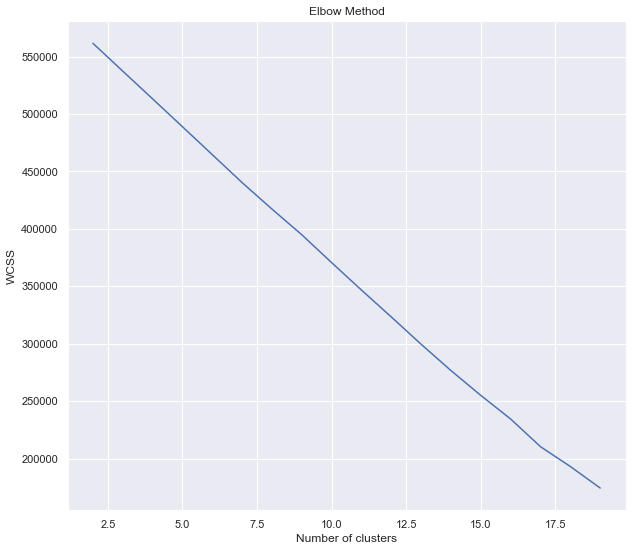

In [379]:
# Using the elbow method to figure out the best number of clusters
wcss = []
for i in range(2,20):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(reduced_cr)
    wcss.append(kmeans.inertia_)
plt.plot(range(2,20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

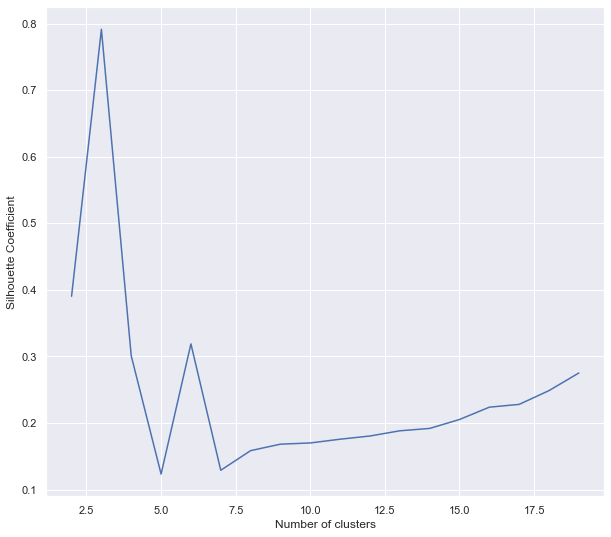

In [380]:
# calculate SC
k_range = range(2, 20)
sil_sc = []
for k in k_range:
    km = KMeans(n_clusters=k, init='k-means++', random_state=42)
    km.fit(reduced_cr)
    sil_sc.append(metrics.silhouette_score(reduced_cr, km.labels_))


# plot the results
plt.plot(k_range, sil_sc)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [381]:
sil_sc

[0.3903128525144223,
 0.7913122613719511,
 0.3007162856133605,
 0.12320563920879159,
 0.31875412229567185,
 0.12891642125103575,
 0.15838302473251598,
 0.1681214293507869,
 0.16991922818675637,
 0.17556988553478683,
 0.18038209449347037,
 0.18818899570705544,
 0.1917482062291559,
 0.20515894406665403,
 0.223665549890061,
 0.22787423713635593,
 0.24856684303885523,
 0.27504408868442176]

Using **k=3** for analysis as Silhoutte Score is highest for that cluster

In [382]:
kmeans_3 = KMeans(n_clusters=3, init='k-means++', random_state=42)
km_3 = kmeans_3.fit(reduced_cr)

In [422]:
feature_list

['proc__19',
 'proc__28',
 'proc__27',
 'proc__34',
 'proc__97',
 'proc__17',
 'proc__8',
 'income_cd',
 'proc__20',
 'proc__83',
 'proc__122',
 'age_cd',
 'proc__58',
 'proc__3',
 'count',
 'proc__26',
 'proc__14',
 'proc__124',
 'proc__99',
 'proc__11',
 'proc__25',
 'proc__2',
 'proc__123',
 'proc__13',
 'proc__22',
 'gender_cd',
 'id',
 'for_review']

In [438]:
feature_list.extend(['id','for_review','predicted_review'])
dataset = clustering_df[feature_list].copy()

df_cluster_pca = pd.concat([dataset.reset_index(drop=True),pd.DataFrame(reduced_cr)],axis =1)

df_cluster_pca["seg_pca_cluster"] = km_3.labels_
df_cluster_pca.head()

,proc__19,proc__28,proc__27,proc__34,proc__97,proc__17,proc__8,income_cd,proc__20,proc__83,...,14,15,16,17,18,19,20,21,22,seg_pca_cluster
0,0,0,0,0,0,0,0,1,0,0,...,-2.881515,1.369709,-2.044364,2.111050,-0.485451,-1.223982,-0.098727,0.366408,-1.783283,0
1,1,0,0,0,0,0,0,0,0,0,...,-0.343219,-0.680862,0.431299,0.204657,-0.198253,0.785036,-0.898275,-0.528605,-0.942467,0
2,0,0,0,0,0,0,0,2,0,0,...,-1.639398,0.841701,0.138071,-1.930236,-0.295244,2.589051,2.633346,-1.903915,-1.818678,0
3,0,0,0,0,0,1,0,3,0,0,...,-0.032381,0.101888,0.349084,-0.241304,0.722750,0.346637,-0.182388,0.217768,-1.484728,0
4,0,0,0,0,0,1,0,2,0,0,...,0.619668,-0.458418,-0.110231,0.701572,0.737957,-0.202560,-0.955301,3.441691,-2.351295,0


In [426]:
df_cluster_pca.seg_pca_cluster.value_counts()

0    24477
2       42
1       12
Name: seg_pca_cluster, dtype: int64

In [440]:
df_cluster_pca.predicted_review = df_cluster_pca.predicted_review.apply(lambda x: 0 if x=="" else x )
df_cluster_pca.predicted_review.value_counts()

1    19531
0     5000
Name: predicted_review, dtype: int64

In [441]:
segments_review = df_cluster_pca.groupby(["seg_pca_cluster"]).agg({"for_review":"sum","predicted_review":"sum"})


In [442]:
#segments_review.pivot_table(columns="seg_pca_cluster",index="for_review",values="id")
segments_review

,for_review,predicted_review
seg_pca_cluster,,
0,4978,19499
1,10,2
2,12,30


# Conclusion:
So it does look like out of the three clusters that we have created, the max of the 5000 review patients are clustered in Cluster 0(total 4978). And with them are also clustered the 19,499 other individuals who were also identified as part of RandomForestClassifier. So these people should definitely be looked at. (Downloading data for these patients)

In [444]:
to_review = df_cluster_pca[(df_cluster_pca.seg_pca_cluster==0)&(df_cluster_pca.predicted_review)==1]
to_review.to_excel("analysis_result/Cluster0_final_patients_to_review.xlsx",index=False)